In [1]:
from pyosrd import OSRD
from pyosrd.schedules import schedule_from_osrd, step_has_fixed_duration, step_station_id, step_type

In [2]:
sim = OSRD(simulation='station_capacity2', dir='/tmp')

[15:05:34,010] [INFO]  [StandaloneSimulationCommand] Loading infra: /tmp/infra.json
[15:05:34,040] [INFO]              [FullInfra] parsing infra
[15:05:34,041] [INFO]              [FullInfra] adaptation to kotlin
[15:05:34,080] [INFO]              [FullInfra] loading signals
[15:05:34,082] [INFO]              [FullInfra] building blocks
[15:05:34,103] [INFO]  [StandaloneSimulationCommand] Loading input: /tmp/simulation.json
[15:05:34,259] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.0
[15:05:34,352] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.1
[15:05:34,359] [INFO]  [StandaloneSimulationCommand] All simulations completed
[15:05:34,359] [INFO]  [StandaloneSimulationCommand] Saving results at: /tmp/results.json


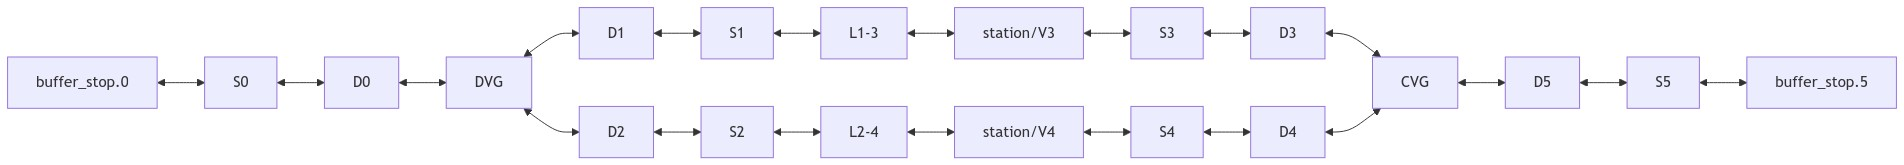

In [3]:
sim.draw_infra_points()

In [4]:
schedule = schedule_from_osrd(sim)
#schedule.draw_graph()

<Axes: xlabel='Time'>

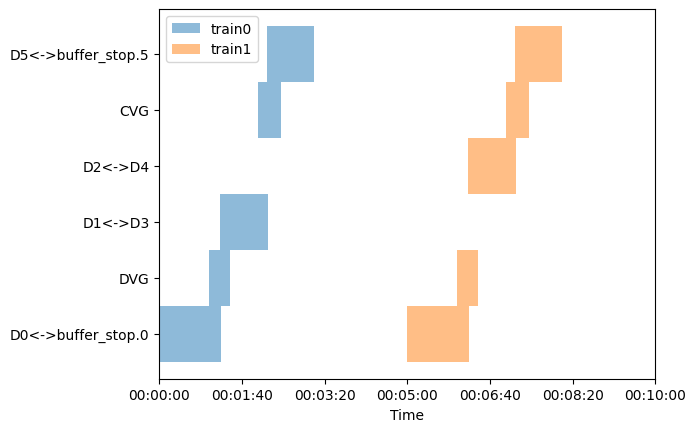

In [5]:
schedule.plot()

# Infos supplémentaires sur les zones
Peuvent être utiles aux agents

In [6]:
display(step_has_fixed_duration(sim))
display(step_station_id(sim))
display(step_type(sim))

,train0,train1
D0<->buffer_stop.0,False,False
DVG,True,True
D1<->D3,False,NaN
D2<->D4,NaN,False
CVG,True,True
D5<->buffer_stop.5,True,True


,train0,train1
D0<->buffer_stop.0,NaN,NaN
DVG,NaN,NaN
D1<->D3,station/V3,NaN
D2<->D4,NaN,station/V4
CVG,NaN,NaN
D5<->buffer_stop.5,NaN,NaN


,train0,train1
D0<->buffer_stop.0,signal,signal
DVG,switch,switch
D1<->D3,station,NaN
D2<->D4,NaN,station
CVG,switch,switch
D5<->buffer_stop.5,last_zone,last_zone


# Weights
Construire des matrices de pondération pour les passer à un agent qui s'en servira pour le calcul d'un retard pondéré

In [7]:
import pyosrd.schedules.weights as weights

display(weights.stations_only(sim))
display(weights.all_steps(sim))

,train0,train1
D0<->buffer_stop.0,0,0
DVG,0,0
D1<->D3,1,0
D2<->D4,0,1
CVG,0,0
D5<->buffer_stop.5,0,0


,train0,train1
D0<->buffer_stop.0,1,1
DVG,1,1
D1<->D3,1,0
D2<->D4,0,1
CVG,1,1
D5<->buffer_stop.5,1,1


In [8]:
w = weights.stations_only(sim)
w.weights.train(0, 2)
w.weights.train_zone(1, 'D0<->buffer_stop.0', 5)
w.weights.train_station_sim(1, 'station', 7, sim)
w

,train0,train1
D0<->buffer_stop.0,0,5
DVG,0,0
D1<->D3,2,0
D2<->D4,0,1
CVG,0,0
D5<->buffer_stop.5,0,0


# Scheduler Agents
C'est une classe abstraite qui a tous les outils pour travailler avec des schedules
1. de manière autonome à partir d'une simulation,
2. ou dans la méthode regulate(),
3. ou encore de manière autonome à partir de schedules custom.

Une classe concrète doit avoir une méthode qui renvoie les délais ajoutés pour chaque couple (zone, train) sous forme d'un dataframe avec les mêmes dimensions qu'un schedule.
```python3
@property
def steps_extra_delays(self) -> pd.DataFrame
```


## 1. de manière autonome à partir d'une simulation

In [9]:
from pyosrd.schedules import Schedule
from pyosrd.agents.scheduler_agent import SchedulerAgent
import pandas as pd

class DummySchedulerAgent(SchedulerAgent):
    @property
    def regulated_schedule(self) -> Schedule:
        """As an example, make train1 stop 60s more in first zone"""
        print('call agent')
        return self.delayed_schedule.add_delay(1, 0, 10).add_delay(1, 3, 60)
    
sim.reset_delays()
sim.add_delay('train0', time_threshold=90, delay=280.)
agent = DummySchedulerAgent('from_sim')
agent.set_schedules_from_osrd(sim)


In [10]:
display(agent.step_has_fixed_duration)
display(agent.weights)

None

,train0,train1
D0<->buffer_stop.0,0,0
DVG,0,0
D1<->D3,1,0
D2<->D4,0,1
CVG,0,0
D5<->buffer_stop.5,0,0


call agent


<Axes: xlabel='Time'>

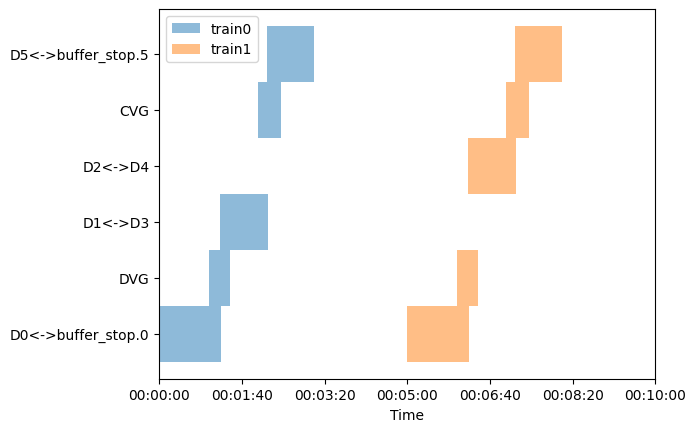

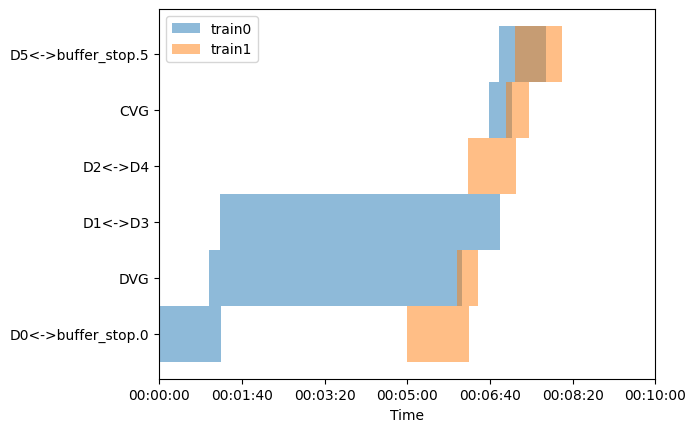

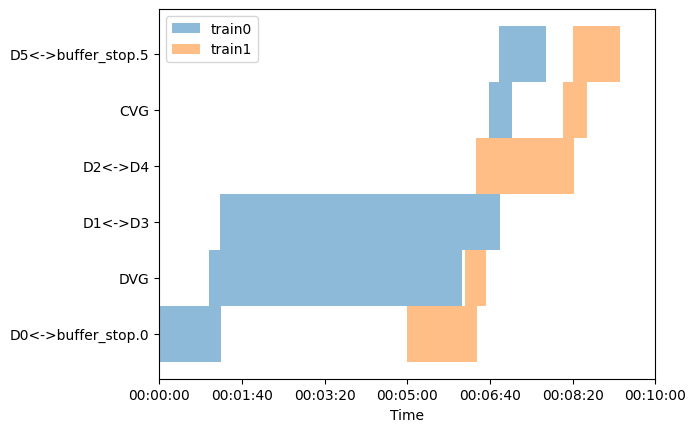

In [11]:
agent.ref_schedule.plot()
agent.delayed_schedule.plot()
agent.regulated_schedule.plot()

## 2. via la méthode regulate de la classe OSRD()

<Axes: title={'center': 'train1 (base)'}>

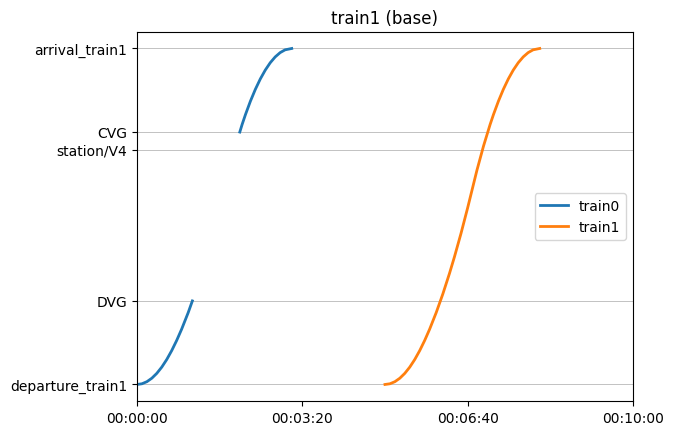

In [12]:
sim.space_time_chart(1)

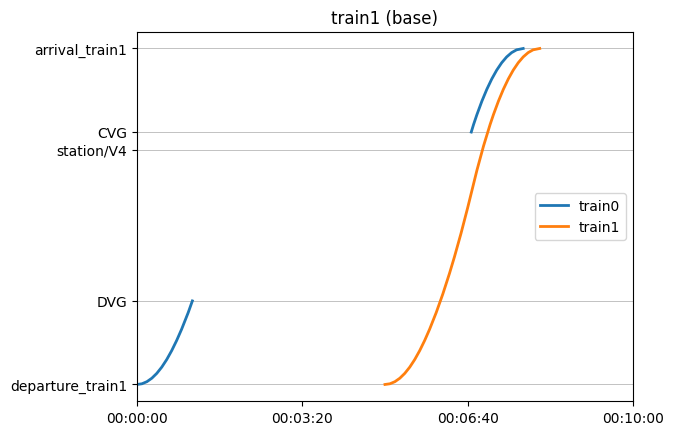

In [13]:
sim.delayed().space_time_chart(1);

call agent
call agent


<Axes: title={'center': 'train1 (base)'}>

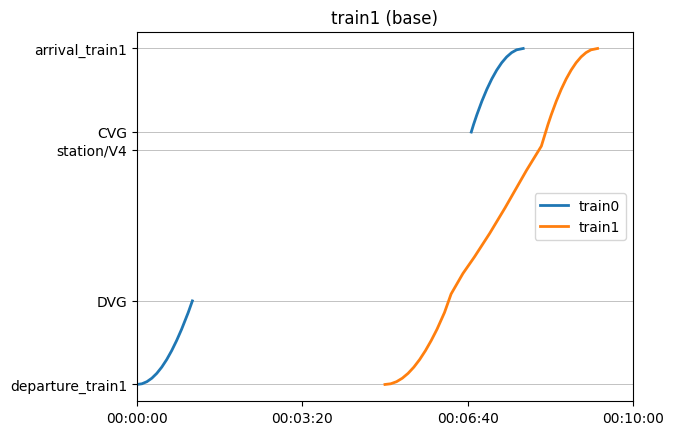

In [14]:
sim.regulate(agent=agent).space_time_chart(1)

## 3. de manière autonome à partir de schedules custom

In [15]:
from pyosrd.schedules import Schedule

schedule = Schedule(6, 2)

schedule.df.at[0, 0] = [0, 1]
schedule.df.at[2, 0] = [1, 2]
schedule.df.at[3, 0] = [2, 3]
schedule.df.at[4, 0] = [3, 4]

schedule.df.at[1, 1] = [1, 2]
schedule.df.at[2, 1] = [2, 3]
schedule.df.at[3, 1] = [3, 4]
schedule.df.at[5, 1] = [4, 5]

delayed = schedule.add_delay(0, 2, .5)

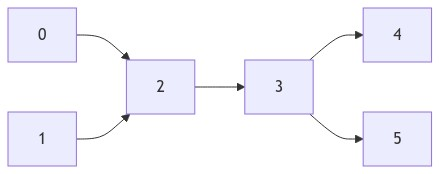

In [16]:
schedule.draw_graph()

<Axes: xlabel='Time'>

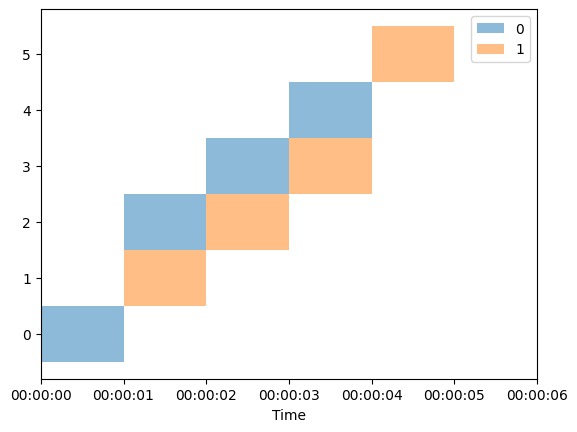

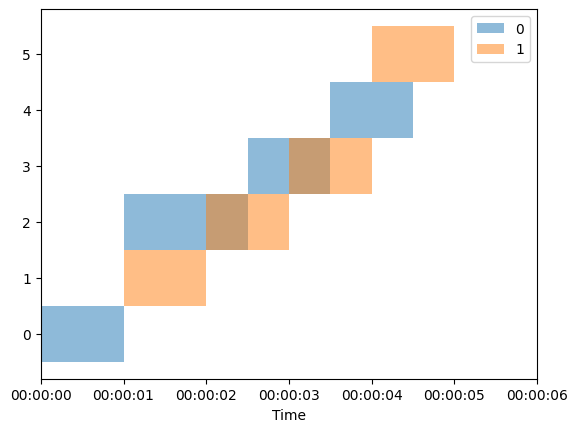

In [17]:
schedule.plot()
delayed.plot()

In [18]:
class TestSchedulerAgent(SchedulerAgent):
    @property
    def regulated_schedule(self) -> Schedule:
        """As an example, make train0 star 1 time unit later"""
        return self.delayed_schedule.add_delay(1, 1, 1)

agent=TestSchedulerAgent(
    'directly_from_schedules',
    ref_schedule=schedule,
    delayed_schedule=delayed,
    # one could had fixed duration zones and/or weights
)

In [21]:
agent.delays_to_add(), agent.departures_to_shift()

({1: {1: 1}}, {})

<Axes: xlabel='Time'>

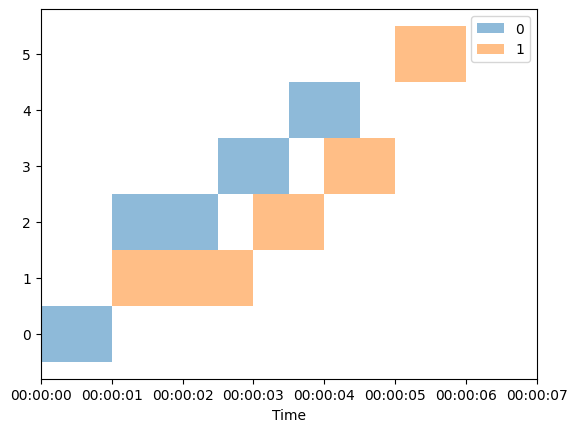

In [20]:
agent.regulated_schedule.plot()